In [1052]:
import mne

In [1053]:
import pandas as pd

In [1054]:
import json

In [1055]:
import matplotlib.pyplot as plt

In [1056]:
import numpy as np

In [1057]:
import matplotlib

In [1058]:
%load_ext autoreload

%autoreload 2
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1059]:
import datetime as dt

In [1060]:
import eeg_events

In [1061]:
%matplotlib inline

# Проверка гипотезы

In [1892]:
baseline_raw = mne.io.read_raw_fif("./valid-data/processed/test-filtered-unprocessed.raw.fif", preload=True)
# baseline_raw = mne.io.read_raw_fif("./valid-data/processed/test-filtered.raw.fif", preload=True)

Opening raw data file ./valid-data/processed/test-filtered-unprocessed.raw.fif...
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.
Reading 0 ... 108903  =      0.000 ...   425.402 secs...


In [1893]:
# baseline_raw = baseline_raw.set_channel_types({
#     "amplitude": "eeg"
# })

In [1894]:
events_df = pd.read_csv("./valid-data/processed/events-test-filtered.csv")

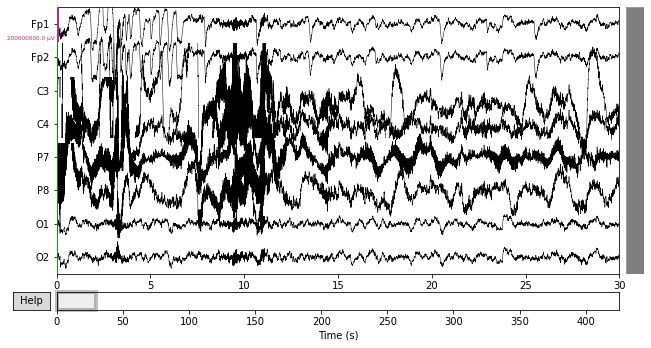

In [1895]:
_ = mne.viz.plot_raw(
    baseline_raw,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

### Добавить STI канал для фиксации событий

In [1896]:
sfreq = int(baseline_raw.info["sfreq"])

In [1897]:
eeg_data = baseline_raw.get_data()

In [1898]:
# eval(events_df["json"].iloc[3])["collect"]

In [1899]:
# Событие - наличие или отсутствие пустой катушки в состоянии 000. Возможно - слишком близкие ивенты, сложно разделить
def check_hypothesis(response):
    response = response["response"]
#     return response.get("collect", False)
    return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000", \
        response["result"]['reels']['view'][0][0] == 5

In [1900]:
# # Событие - состояние 000
# def check_hypothesis(response):
#     response = response["response"]
#     return "".join([str(s) for s in response['result']['state']['towerStages']]) == "000"

In [1901]:
events_df["type_proxy"] = events_df["json"].apply(lambda x: eval(x)).apply(check_hypothesis)
# events_df["type_proxy"] = [(True, x > 315 // 2) for x in events_df.index]

In [1902]:
events_df["type"] = 'unknown'

In [1903]:
events_df.loc[events_df["type_proxy"] == (True, True), "type"] = 'empty reel'
events_df.loc[events_df["type_proxy"] == (True, False), "type"] = 'another action'

In [1904]:
events_df["type"].value_counts()

unknown           234
another action     41
empty reel         40
Name: type, dtype: int64

In [1905]:
stim_channel = np.zeros(eeg_data.shape[1])

true_timestamps = (events_df[events_df["type"] == 'empty reel']["timestamp"] * sfreq).astype(int)
stim_channel[true_timestamps[true_timestamps < stim_channel.shape[0]]] = 1

false_timestamps = (events_df[events_df["type"] == 'another action']["timestamp"] * sfreq).astype(int)
stim_channel[false_timestamps[false_timestamps < stim_channel.shape[0]]] = 2

In [1906]:
stim_info = mne.create_info(['STI'], baseline_raw.info['sfreq'], ['stim'])

In [1907]:
stim_raw = mne.io.RawArray(stim_channel.reshape(1, -1), stim_info)

Creating RawArray with float64 data, n_channels=1, n_times=108904
    Range : 0 ... 108903 =      0.000 ...   425.402 secs
Ready.


In [1908]:
baseline_raw.add_channels([stim_raw], force_update_info=True)

<Raw | test-filtered-unprocessed.raw.fif, 9 x 108904 (425.4 s), ~7.5 MB, data loaded>

In [1909]:
events = mne.find_events(baseline_raw, stim_channel="STI")

81 events found
Event IDs: [1 2]


In [1910]:
raw_part = baseline_raw.copy().pick(["Fp1", "Fp2", "O1", "O2"])
# raw_part = baseline_raw.copy()

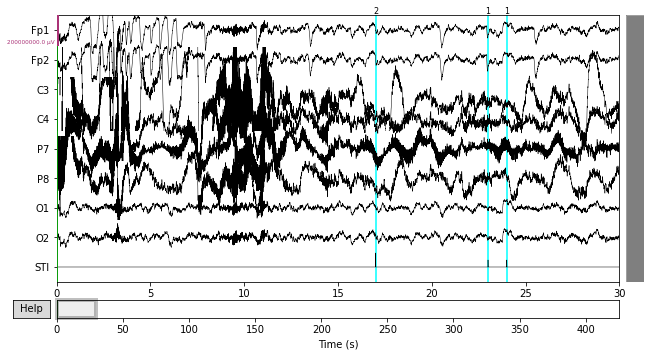

In [1911]:
_ = mne.viz.plot_raw(
    baseline_raw,
    events,
    duration=30, 
    start=0, 
    scalings=100,
    show=True
)

In [1912]:
epochs = mne.Epochs(
    baseline_raw,
    events,
    tmin=0,
    tmax=10,
    preload=True,
    baseline=None#(None, 0)
)

Not setting metadata
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Loading data for 81 events and 2561 original time points ...
1 bad epochs dropped


In [1913]:
epochs_part = epochs.copy().pick(["Fp1"])
# epochs_part = epochs.copy().pick(["amplitude"])

Need more than one channel to make topography for eeg. Disabling interactivity.


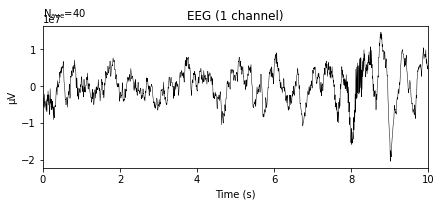

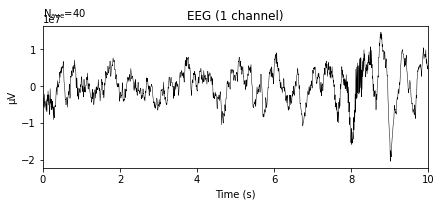

In [1914]:
# Средняя попытка для пустой катушки
epochs_part['1'].average().plot()

Need more than one channel to make topography for eeg. Disabling interactivity.


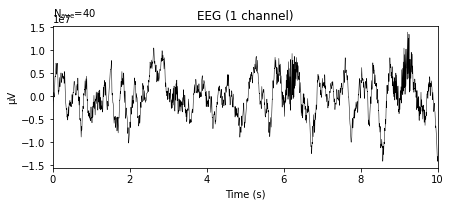

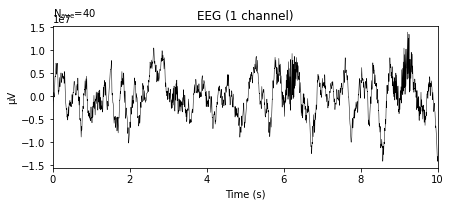

In [1915]:
# Средняя попытка для других символов
epochs_part['2'].average().plot()

# Проверка гипотезы

TODO уточнить ожидаемый размер эффекта

Ожидаемый результат - для пустой катушки амплитуда альфа-ритма должна быть больше, чем для других символов

In [1916]:
empty_reel_data = epochs_part['1'].get_data()

In [1917]:
other_action_data = epochs_part['2'].get_data()

In [1918]:
other_action_data.shape

(40, 1, 2561)

In [1919]:
def filter_by_mean(data):
    mean_abs_values = np.abs(data.max(axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[0:]]

In [1920]:
from scipy import stats

In [1921]:
def filter_by_std(data):
    mean_abs_values = (data.std(axis=2)).reshape(-1)
    return data[np.argsort(-mean_abs_values)[5:]]

In [1922]:
def filter_by_kurtosis(data):
    mean_abs_values = (stats.kurtosis(data, axis=2)).max(axis=1)
    return data[np.argsort(-mean_abs_values)[10:]]

Simplest filtering

In [1923]:
# empty_reel_data = filter_by_kurtosis(empty_reel_data)
other_action_data = filter_by_kurtosis(other_action_data)

In [1924]:
# other_action_data.mean(axis=0).mean(axis=0)

In [1925]:
import seaborn as sns

In [1926]:
import plotly.express as px

In [1927]:
# plt.figure(figsize=(20, 10))
# plt.plot(other_action_data.reshape(other_action_data.shape[0], -1).T, color='blue')
# plt.plot(empty_reel_data.reshape(empty_reel_data.shape[0], -1).T, color='red')
# plt.show()

In [1928]:
import scipy

In [1929]:
def fft(signal):
#     print(signal.shape)
    result = scipy.signal.stft(
        signal, 
        256, 
        window='boxcar', 
        nperseg=256, 
        noverlap=256-16, 
#         padded=False, 
#         return_onesided=False, 
#         boundary=None
    )
#     print(result[-1].shape)
    return result[-1]

In [1930]:
def fft_group(group):
    return np.stack([fft(d[0]) for d in group])

In [1931]:
 np.abs(fft_group(empty_reel_data)).shape

(40, 129, 162)

In [1947]:
start_frequency = 8
end_frequency = 12

In [1954]:
# empty_reel_frequencies = np.abs(np.fft.fft(empty_reel_data, 256, axis=-1))[:, :, 0:30]
empty_reel_frequencies = np.abs(fft_group(empty_reel_data))[:, start_frequency:end_frequency, :]

In [1955]:
# empty_reel_frequencies = empty_reel_data.mean(axis=-1)
# other_frequencies = other_action_data.mean(axis=-1)

In [1956]:
import seaborn as sns

In [1957]:
# other_frequencies = np.abs(np.fft.fft(other_action_data, 256, axis=-1))[:, :, 0:30]
other_frequencies = np.abs(fft_group(other_action_data))[:, start_frequency:end_frequency, :]

3. EEG mid-beta activity in the left frontal region of the brain is lower in the 
flow state than in the boredom state.

In [1958]:
# plt.plot(np.log(empty_reel_frequencies[:, 0, :].mean(axis=0)), label="Empty reel")
# plt.plot(np.log(other_frequencies[:, 0, :].mean(axis=0)), label="Other events")
# plt.axvline(4)
# plt.axvline(7)
# plt.axvline(14)
# plt.axvline(20)
# plt.legend()

In [1959]:
# sns.heatmap(np.log(empty_reel_frequencies.mean(axis=1)), vmin=0, vmax=9)
# plt.axvline(14)
# plt.axvline(20)

In [1960]:
# sns.heatmap(np.log(other_frequencies.mean(axis=1)), vmin=0, vmax=9)
# plt.axvline(14)
# plt.axvline(20)

In [1961]:
# sample_empty = empty_reel_frequencies[:, :, 15:20].mean(axis=-1).mean(axis=-1)

In [1962]:
# sample_other = other_frequencies[:, :, 15:20].mean(axis=-1).mean(axis=-1)

In [1963]:
empty_reel_frequencies.shape

(40, 4, 162)

In [1964]:
sample_empty = empty_reel_frequencies.sum(axis=1)
sample_other = other_frequencies.sum(axis=1)

In [1965]:
# sample_empty = empty_reel_data.mean(axis=2).mean(axis=1) #.std(axis=2).mean(axis=1)

In [1966]:
# sample_other = other_action_data.mean(axis=2).mean(axis=1)

In [1967]:
bins=np.linspace(np.quantile(sample_other, 0.01), np.quantile(sample_other, 0.99), 20)

TODO P-value change over time

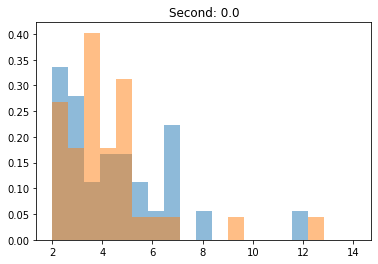

3.9929915393566824 4.326874284297082
Ttest_indResult(statistic=0.6433495845249065, pvalue=0.5221610443902136)
MannwhitneyuResult(statistic=550.0, pvalue=0.2784484373996384)


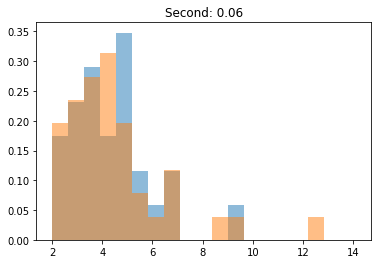

4.51636572104408 4.111332031673026
Ttest_indResult(statistic=-0.8697915998159274, pvalue=0.3874742749281116)
MannwhitneyuResult(statistic=553.0, pvalue=0.2905243745182282)


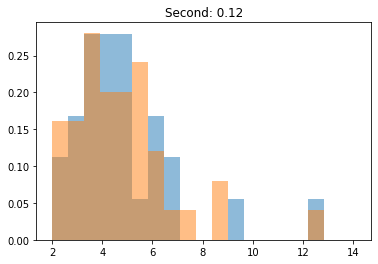

4.707739495987292 4.65538719652133
Ttest_indResult(statistic=-0.09992032910703195, pvalue=0.9207015803081811)
MannwhitneyuResult(statistic=582.0, pvalue=0.4177367663464297)


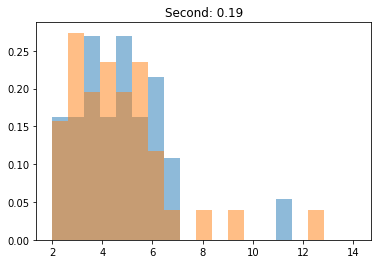

4.661958727225257 4.596407676845903
Ttest_indResult(statistic=-0.13946981545526224, pvalue=0.8894911652761017)
MannwhitneyuResult(statistic=596.0, pvalue=0.48343375556735046)


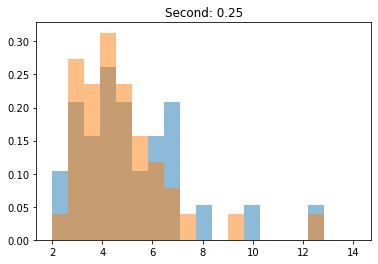

4.742143545746652 5.143321711680804
Ttest_indResult(statistic=0.8117040690612566, pvalue=0.4197937652509488)
MannwhitneyuResult(statistic=542.0, pvalue=0.24749320062960456)


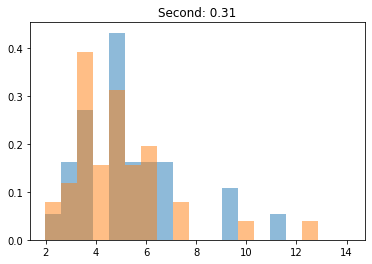

4.881335355363211 5.181468154895864
Ttest_indResult(statistic=0.5989067575899756, pvalue=0.5512251057860484)
MannwhitneyuResult(statistic=530.0, pvalue=0.20473881081569384)


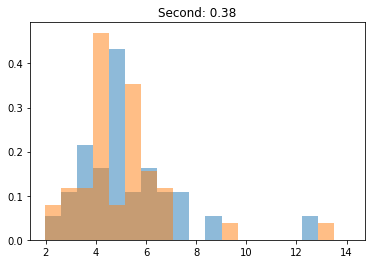

4.998864095296964 5.175880755548891
Ttest_indResult(statistic=0.3610893392690699, pvalue=0.71915209849509)
MannwhitneyuResult(statistic=582.0, pvalue=0.4177367663464297)


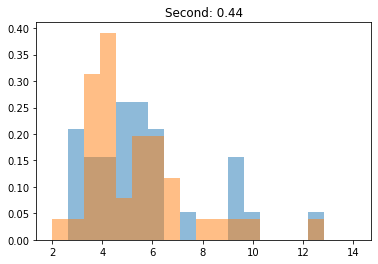

5.315777006079304 5.61424469365043
Ttest_indResult(statistic=0.55831920891737, pvalue=0.5784602176115636)
MannwhitneyuResult(statistic=569.0, pvalue=0.35868782018733764)


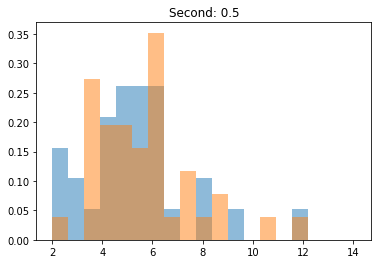

5.677890232278726 5.287833175902403
Ttest_indResult(statistic=-0.7878384973218061, pvalue=0.43352890750248196)
MannwhitneyuResult(statistic=536.0, pvalue=0.2255428142330319)


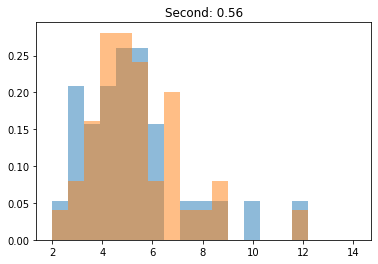

5.628760890668379 5.267048761050083
Ttest_indResult(statistic=-0.654492315108919, pvalue=0.5150023331170444)
MannwhitneyuResult(statistic=537.0, pvalue=0.22912288326915503)


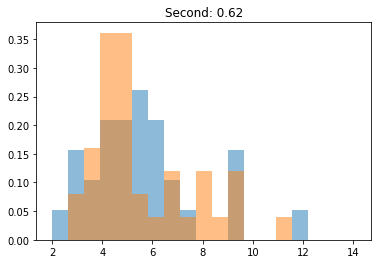

5.516763192730891 5.57670698395071
Ttest_indResult(statistic=0.11561763545744318, pvalue=0.9082963376872346)
MannwhitneyuResult(statistic=586.0, pvalue=0.4363556505447304)


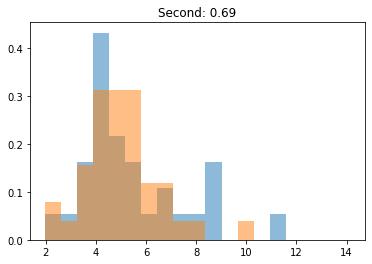

5.073552833920078 5.7646285643900415
Ttest_indResult(statistic=1.396481611138473, pvalue=0.1671112784824397)
MannwhitneyuResult(statistic=560.0, pvalue=0.3196138935484081)


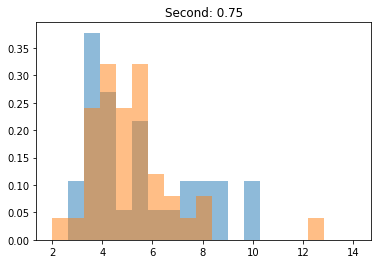

5.093977508385349 5.854619699719894
Ttest_indResult(statistic=1.3646409547939227, pvalue=0.1768648148737443)
MannwhitneyuResult(statistic=556.0, pvalue=0.302839898964452)


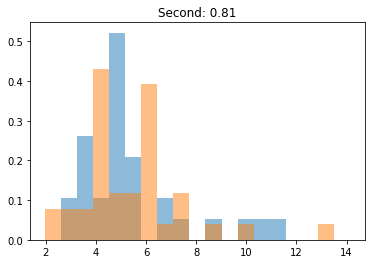

5.454206941838121 5.476802094433269
Ttest_indResult(statistic=0.043922869445225714, pvalue=0.965094611407108)
MannwhitneyuResult(statistic=576.0, pvalue=0.39016320569654583)


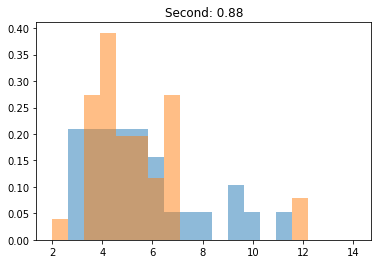

5.291420243245868 5.436199856096312
Ttest_indResult(statistic=0.29085841915154165, pvalue=0.7720448931745061)
MannwhitneyuResult(statistic=596.0, pvalue=0.48343375556735046)


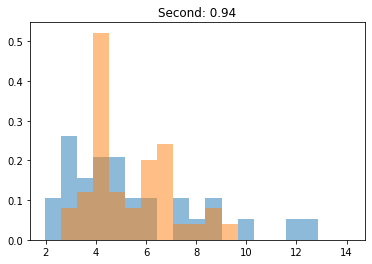

5.304950626925395 5.513934117624691
Ttest_indResult(statistic=0.3936614176712046, pvalue=0.6950626978093819)
MannwhitneyuResult(statistic=567.0, pvalue=0.34985793562805334)


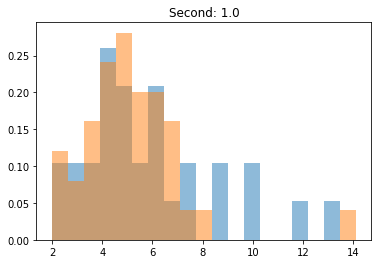

5.070638779640296 5.953293779844926
Ttest_indResult(statistic=1.570756002249923, pvalue=0.12088117854816476)
MannwhitneyuResult(statistic=507.0, pvalue=0.1361518046848666)


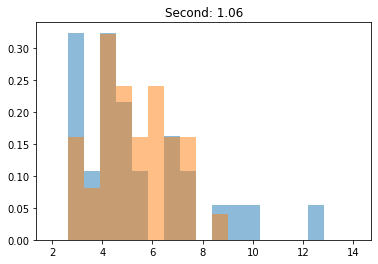

5.606992891885841 5.282568530664753
Ttest_indResult(statistic=-0.5159193064407651, pvalue=0.6075842927491412)
MannwhitneyuResult(statistic=533.0, pvalue=0.21499469677367938)


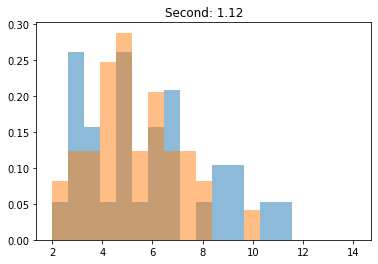

5.348760172404401 5.77899972116759
Ttest_indResult(statistic=0.753988704285737, pvalue=0.4534590426716725)
MannwhitneyuResult(statistic=546.0, pvalue=0.2627376262125505)


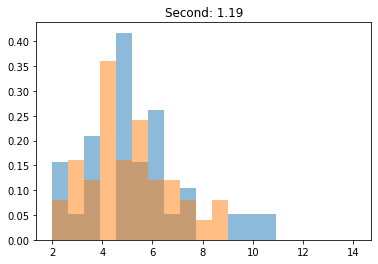

5.293868601974441 5.425708296800284
Ttest_indResult(statistic=0.2543511617241056, pvalue=0.7999918674532231)
MannwhitneyuResult(statistic=554.0, pvalue=0.29460346282901306)


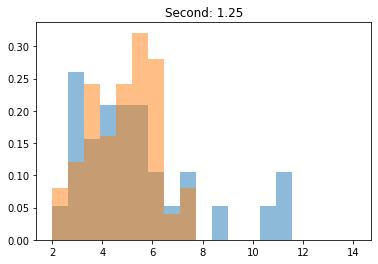

5.111318099715578 5.461232335979108
Ttest_indResult(statistic=0.6342084949890779, pvalue=0.5280725993142443)
MannwhitneyuResult(statistic=582.0, pvalue=0.4177367663464297)


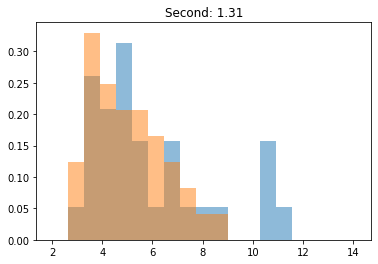

5.1841745482780555 5.915305710967581
Ttest_indResult(statistic=1.3155464391434235, pvalue=0.19274472714839042)
MannwhitneyuResult(statistic=494.0, pvalue=0.10527497560318327)


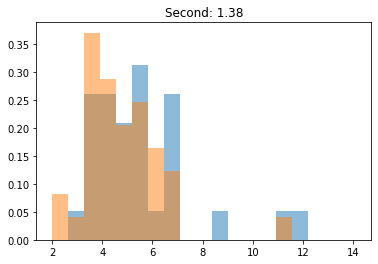

4.977963646879504 5.549950512690016
Ttest_indResult(statistic=1.0689646871742342, pvalue=0.2888656040583799)
MannwhitneyuResult(statistic=485.0, pvalue=0.08709468593749753)


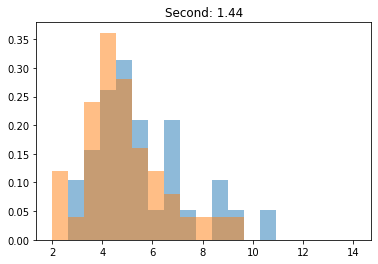

5.1510062033917 5.614115280181907
Ttest_indResult(statistic=0.8984014776312327, pvalue=0.3721417105788496)
MannwhitneyuResult(statistic=491.0, pvalue=0.09893250266603837)


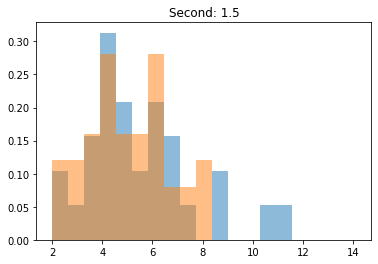

5.317068939080935 5.483172057328505
Ttest_indResult(statistic=0.304224200216477, pvalue=0.7618861362221513)
MannwhitneyuResult(statistic=571.0, pvalue=0.3675938903658421)


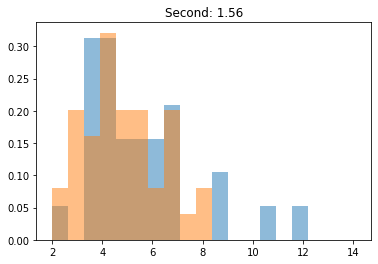

5.153524875731864 5.5217935634848665
Ttest_indResult(statistic=0.6798378049703472, pvalue=0.49891508354493896)
MannwhitneyuResult(statistic=539.0, pvalue=0.23637774836672393)


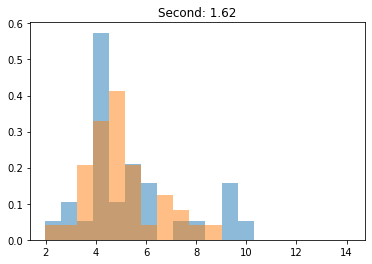

5.260375058208315 5.457924185890233
Ttest_indResult(statistic=0.37285257820204926, pvalue=0.710417865482293)
MannwhitneyuResult(statistic=581.0, pvalue=0.41310902364314284)


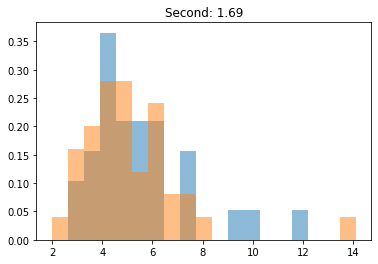

5.047919241758329 5.466494901279672
Ttest_indResult(statistic=0.8446842842879629, pvalue=0.40124925018058555)
MannwhitneyuResult(statistic=546.0, pvalue=0.2627376262125505)


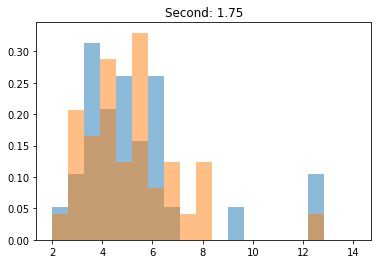

4.96696224422461 5.317353011406363
Ttest_indResult(statistic=0.6462979907520724, pvalue=0.5202617489127341)
MannwhitneyuResult(statistic=568.0, pvalue=0.354263084328722)


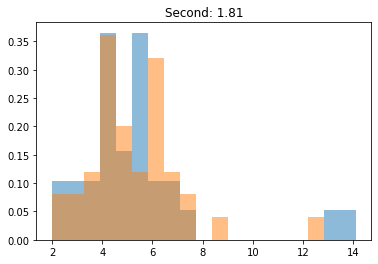

5.195487904106389 5.315976806778251
Ttest_indResult(statistic=0.22297088065128698, pvalue=0.8242265949623095)
MannwhitneyuResult(statistic=581.0, pvalue=0.41310902364314284)


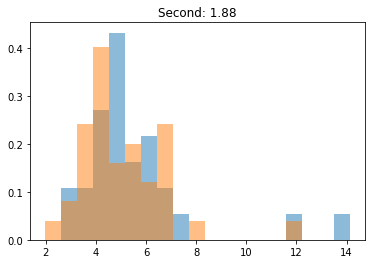

5.296701404531694 5.456441995159712
Ttest_indResult(statistic=0.28735344817460895, pvalue=0.7747155766422931)
MannwhitneyuResult(statistic=549.0, pvalue=0.27447817743797676)


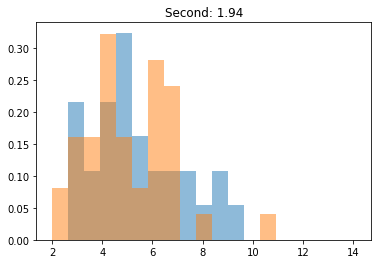

5.299834462106889 5.676045537845498
Ttest_indResult(statistic=0.6656145086628251, pvalue=0.5079091204920315)
MannwhitneyuResult(statistic=534.0, pvalue=0.21847851499660348)


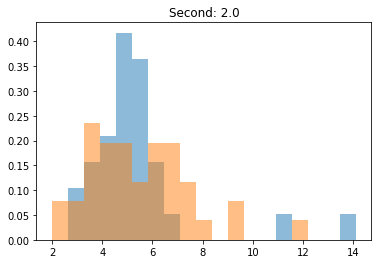

5.469462813808562 5.370077112371836
Ttest_indResult(statistic=-0.19872666367694455, pvalue=0.843069540781433)
MannwhitneyuResult(statistic=564.0, pvalue=0.33676528128783534)


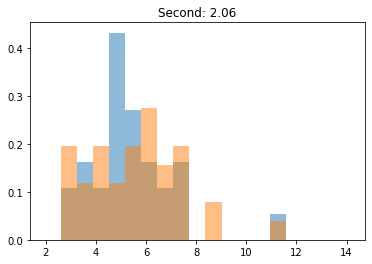

5.583792482950555 5.894135054804949
Ttest_indResult(statistic=0.5251164252797795, pvalue=0.6012102653162745)
MannwhitneyuResult(statistic=575.0, pvalue=0.38561686375123355)


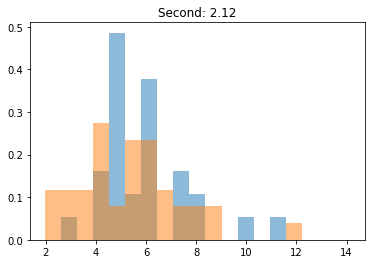

5.424252160953005 6.157534451095933
Ttest_indResult(statistic=1.393724867110153, pvalue=0.1679390509377544)
MannwhitneyuResult(statistic=506.0, pvalue=0.13357691037766822)


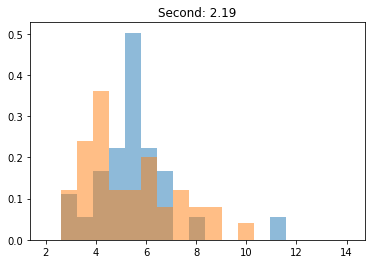

5.3174372220827335 5.758531447663797
Ttest_indResult(statistic=0.8687090318775076, pvalue=0.3880620732026383)
MannwhitneyuResult(statistic=524.0, pvalue=0.18512100023543693)


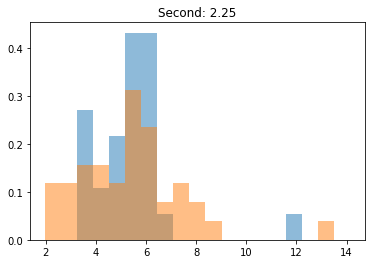

5.345907955358939 5.806770744099979
Ttest_indResult(statistic=0.8473340318644346, pvalue=0.39978144842442276)
MannwhitneyuResult(statistic=540.0, pvalue=0.24005206694485576)


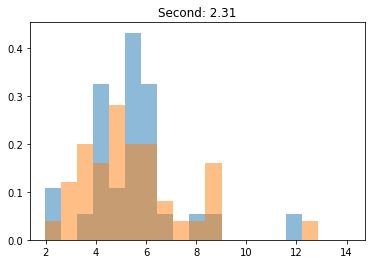

5.4472005258005485 5.7718434280562265
Ttest_indResult(statistic=0.5941487686202485, pvalue=0.5543842094842204)
MannwhitneyuResult(statistic=559.0, pvalue=0.3153838549756317)


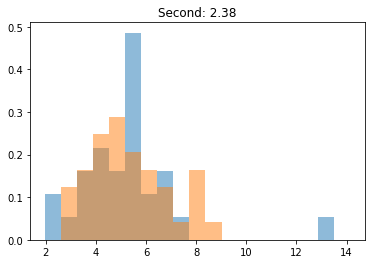

5.493390029468358 5.608917704217487
Ttest_indResult(statistic=0.19842373955092152, pvalue=0.8433055838946619)
MannwhitneyuResult(statistic=588.0, pvalue=0.4457209603480758)


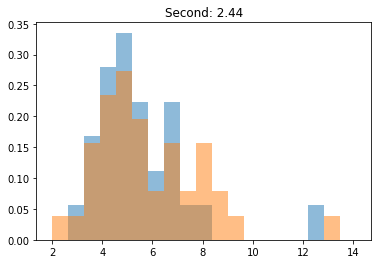

5.820283884197066 5.661815298276354
Ttest_indResult(statistic=-0.2764974564310837, pvalue=0.7830046903235958)
MannwhitneyuResult(statistic=538.0, pvalue=0.23273460574127863)


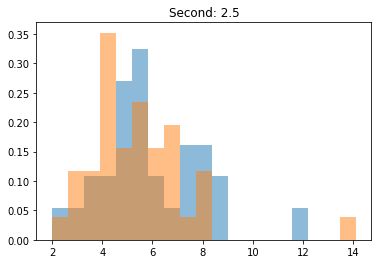

5.396505338526538 6.266300729468006
Ttest_indResult(statistic=1.543945248650955, pvalue=0.1272429682841778)
MannwhitneyuResult(statistic=478.0, pvalue=0.0746596905890418)


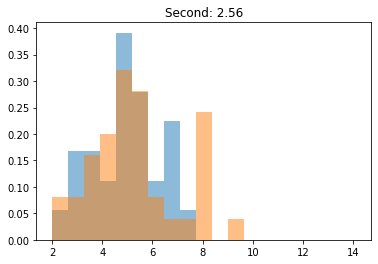

5.574788715752265 5.6240968164479
Ttest_indResult(statistic=0.07787279023426333, pvalue=0.9381579347884084)
MannwhitneyuResult(statistic=572.0, pvalue=0.37207412413706814)


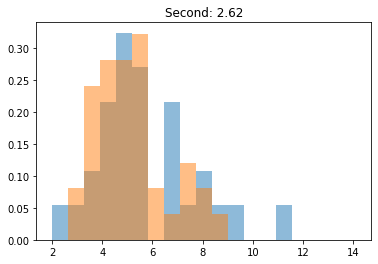

5.485987610167265 6.009011103548961
Ttest_indResult(statistic=0.8639820880743265, pvalue=0.3906351465981456)
MannwhitneyuResult(statistic=513.0, pvalue=0.15231240373643817)


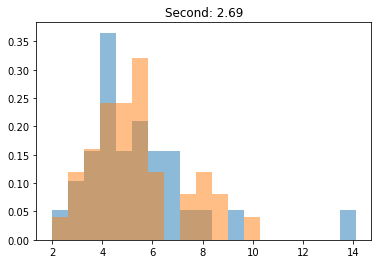

5.606802698389 5.464506808766343
Ttest_indResult(statistic=-0.2571915617965669, pvalue=0.7978075523118646)
MannwhitneyuResult(statistic=583.0, pvalue=0.4223759293923297)


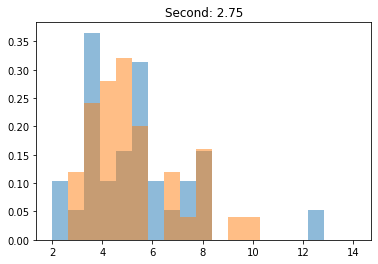

5.169133570159109 5.3525324535103085
Ttest_indResult(statistic=0.3756425780022104, pvalue=0.7083519237892848)
MannwhitneyuResult(statistic=568.0, pvalue=0.354263084328722)


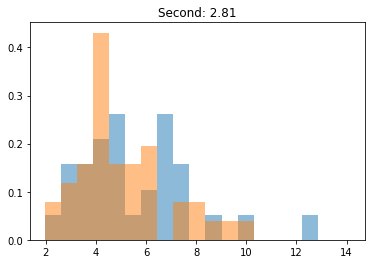

5.174346702510867 5.636079001023856
Ttest_indResult(statistic=0.9216624055012991, pvalue=0.3599631926352367)
MannwhitneyuResult(statistic=528.0, pvalue=0.1980661797309871)


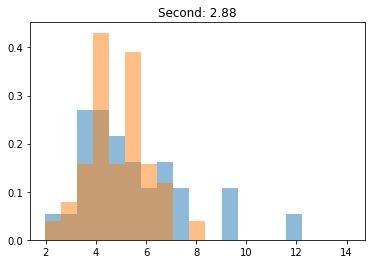

4.878799638301267 5.7661995362116105
Ttest_indResult(statistic=1.8691481080765202, pvalue=0.06590918316141738)
MannwhitneyuResult(statistic=513.0, pvalue=0.15231240373643817)


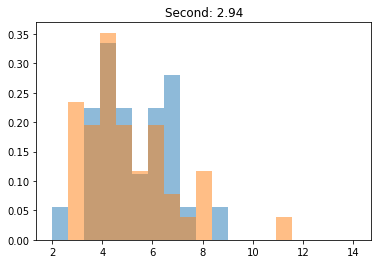

5.039947885184334 5.442506003593942
Ttest_indResult(statistic=0.8137133860971452, pvalue=0.41864941179002146)
MannwhitneyuResult(statistic=519.0, pvalue=0.16969803082055623)


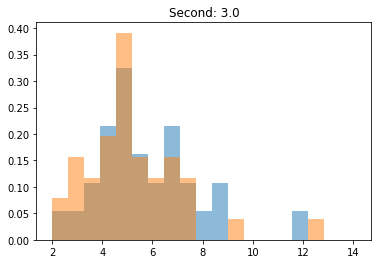

5.196950752135003 5.619091784518576
Ttest_indResult(statistic=0.8712779659735994, pvalue=0.3866681321357729)
MannwhitneyuResult(statistic=515.0, pvalue=0.15797132481327592)


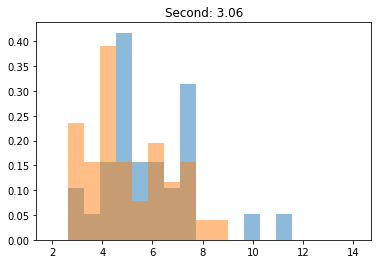

5.071050635420992 5.841671221851389
Ttest_indResult(statistic=1.8512300206476366, pvalue=0.06847939399436648)
MannwhitneyuResult(statistic=446.0, pvalue=0.03424951165380191)


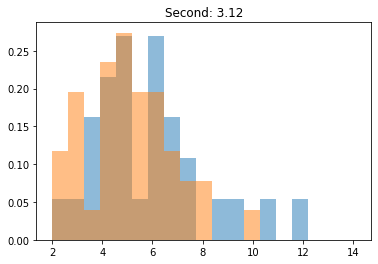

5.107662519865704 5.6741063346151
Ttest_indResult(statistic=1.176338396177478, pvalue=0.24356137787775362)
MannwhitneyuResult(statistic=536.0, pvalue=0.2255428142330319)


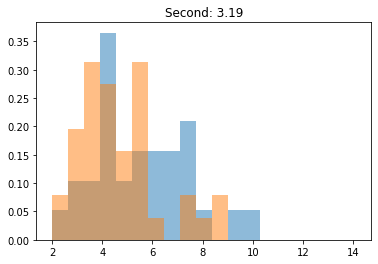

4.7197233504270875 5.583761781809439
Ttest_indResult(statistic=2.095772565133242, pvalue=0.03982745260394089)
MannwhitneyuResult(statistic=422.0, pvalue=0.017578847091020755)


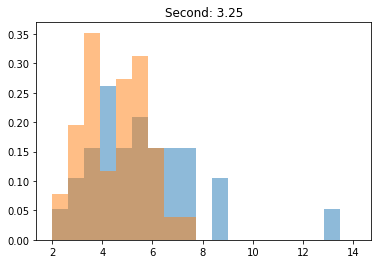

4.511394695927551 5.6183790177686745
Ttest_indResult(statistic=2.635568082567622, pvalue=0.01039551510535283)
MannwhitneyuResult(statistic=417.0, pvalue=0.015160311757904794)


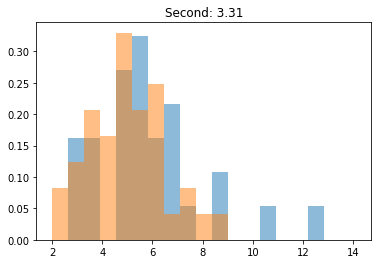

4.83348742845936 5.726344867969895
Ttest_indResult(statistic=1.8985085921079619, pvalue=0.06187348275677083)
MannwhitneyuResult(statistic=458.0, pvalue=0.04654718057813102)


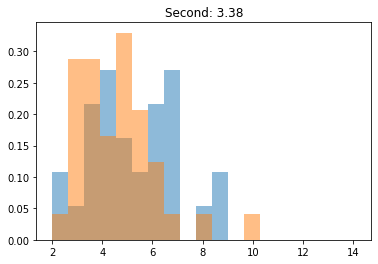

4.442178000264688 5.559346370687958
Ttest_indResult(statistic=2.267312421303003, pvalue=0.026554007759519074)
MannwhitneyuResult(statistic=419.0, pvalue=0.01609107305403464)


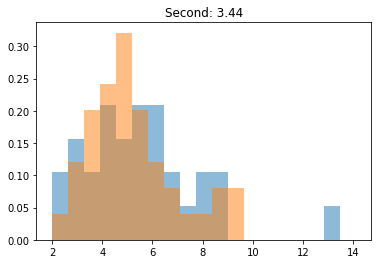

5.17691686654765 5.539044147852975
Ttest_indResult(statistic=0.7140439093093747, pvalue=0.477643901057888)
MannwhitneyuResult(statistic=550.0, pvalue=0.2784484373996384)


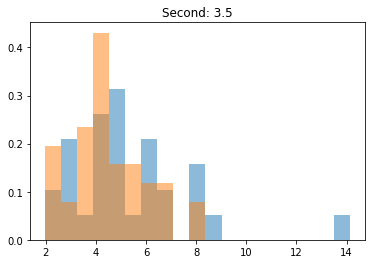

4.523994727188996 5.3280995952245105
Ttest_indResult(statistic=1.7516429688352273, pvalue=0.08434398390253614)
MannwhitneyuResult(statistic=471.0, pvalue=0.06362774916261099)


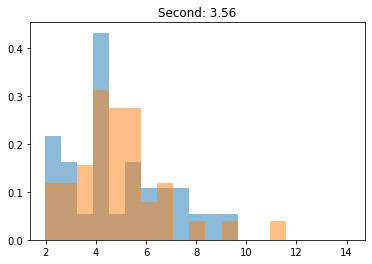

4.908505465888529 5.329953706957602
Ttest_indResult(statistic=0.7801770600669501, pvalue=0.4379939481476869)
MannwhitneyuResult(statistic=564.0, pvalue=0.33676528128783534)


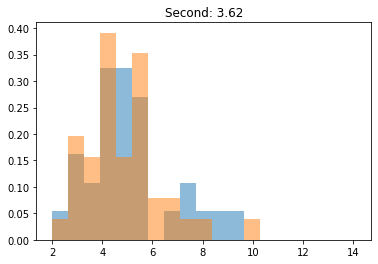

4.824191361219144 5.541452326250664
Ttest_indResult(statistic=1.3852248763316055, pvalue=0.1705111736848022)
MannwhitneyuResult(statistic=527.0, pvalue=0.19477969110450688)


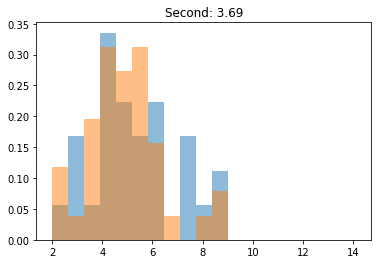

4.912329316845848 5.456356862578664
Ttest_indResult(statistic=1.127885869964407, pvalue=0.26333203867339294)
MannwhitneyuResult(statistic=544.0, pvalue=0.25505583534575577)


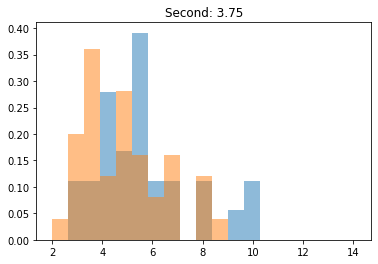

5.100822171783027 5.339627436622024
Ttest_indResult(statistic=0.445504795183639, pvalue=0.6573701313121137)
MannwhitneyuResult(statistic=513.0, pvalue=0.15231240373643817)


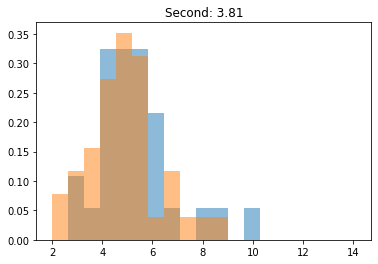

4.860118598422073 5.289963531173504
Ttest_indResult(statistic=1.152400110434276, pvalue=0.2531919356400769)
MannwhitneyuResult(statistic=508.0, pvalue=0.13876046422598942)


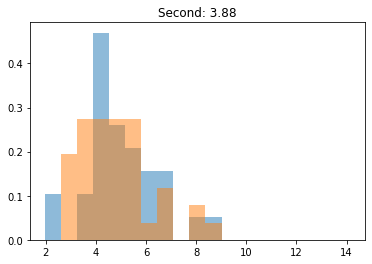

4.834445542184406 5.091887773636965
Ttest_indResult(statistic=0.726349433748751, pvalue=0.4701174715278572)
MannwhitneyuResult(statistic=526.0, pvalue=0.19152659054364674)


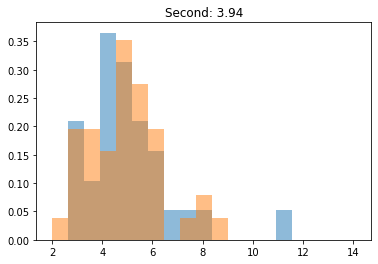

4.921005423075487 5.03905975151143
Ttest_indResult(statistic=0.30324905186877127, pvalue=0.7626259121091247)
MannwhitneyuResult(statistic=595.0, pvalue=0.47870454117454486)


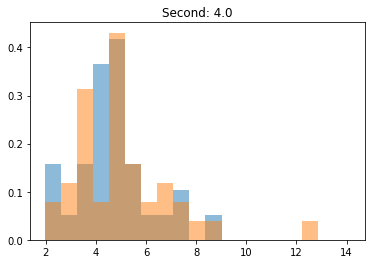

5.0164794750817645 4.707925542507939
Ttest_indResult(statistic=-0.7214293961232202, pvalue=0.47311865339835535)
MannwhitneyuResult(statistic=538.0, pvalue=0.23273460574127863)


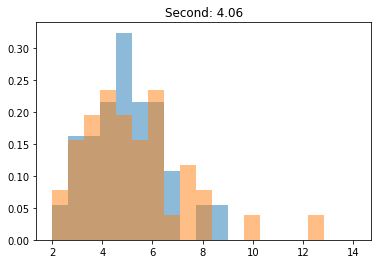

5.269051883055349 4.855230903276223
Ttest_indResult(statistic=-0.9072622627137704, pvalue=0.3674720799724779)
MannwhitneyuResult(statistic=547.0, pvalue=0.26662242529442914)


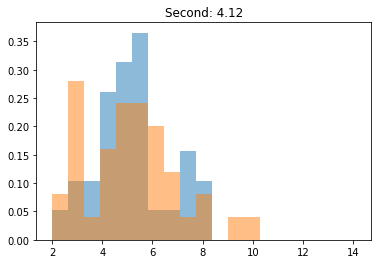

5.077440346088963 5.121328884182443
Ttest_indResult(statistic=0.10398077143310616, pvalue=0.9174906826105644)
MannwhitneyuResult(statistic=589.0, pvalue=0.45041533457597316)


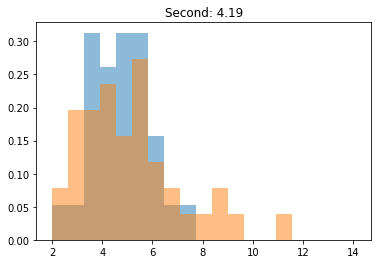

5.160909266977848 4.755082385326542
Ttest_indResult(statistic=-0.9890965473320685, pvalue=0.326122416190991)
MannwhitneyuResult(statistic=570.0, pvalue=0.3631316043748767)


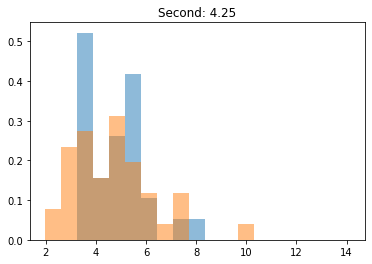

4.68696893272965 4.785325663132584
Ttest_indResult(statistic=0.2807682393987308, pvalue=0.779740661532054)
MannwhitneyuResult(statistic=538.0, pvalue=0.23273460574127863)


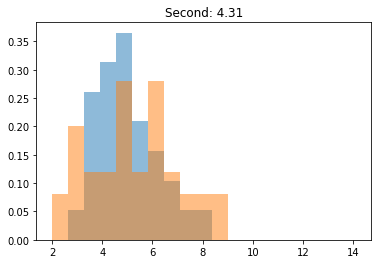

5.151763132425009 4.997334185936791
Ttest_indResult(statistic=-0.403695809365907, pvalue=0.6877031374456697)
MannwhitneyuResult(statistic=565.0, pvalue=0.3411085153778096)


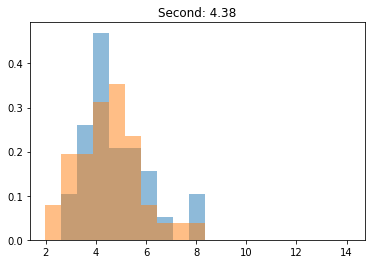

4.514163538874023 4.84552024307809
Ttest_indResult(statistic=1.089820260189881, pvalue=0.2796393510394227)
MannwhitneyuResult(statistic=525.0, pvalue=0.18830699234381937)


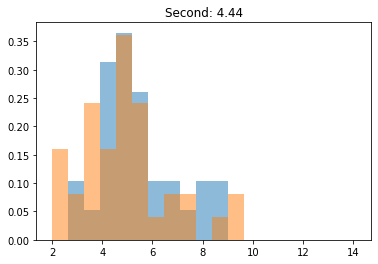

4.851983381915483 5.397815340816334
Ttest_indResult(statistic=1.2792218213365107, pvalue=0.20516693293380137)
MannwhitneyuResult(statistic=486.0, pvalue=0.0889905701260289)


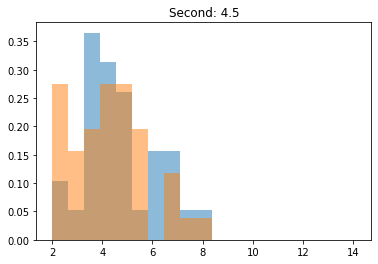

4.3488500700157475 4.748607491463089
Ttest_indResult(statistic=1.1002016223573334, pvalue=0.2751238974003833)
MannwhitneyuResult(statistic=531.0, pvalue=0.2081246713393723)


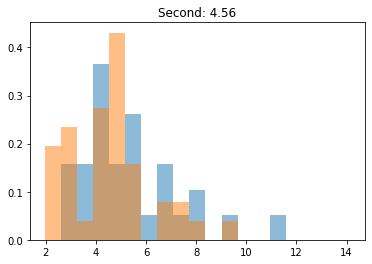

4.584674607886186 5.391544556079889
Ttest_indResult(statistic=1.8548179038161727, pvalue=0.0679581012126902)
MannwhitneyuResult(statistic=465.0, pvalue=0.05521969346796555)


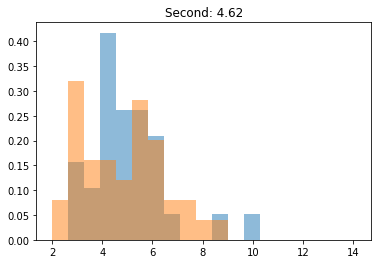

4.7438172066534765 5.060981721566011
Ttest_indResult(statistic=0.8080237603047403, pvalue=0.421894654910172)
MannwhitneyuResult(statistic=537.0, pvalue=0.22912288326915503)


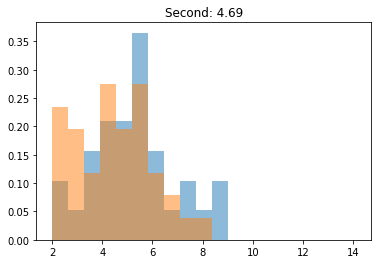

4.517006724112233 5.307394223122833
Ttest_indResult(statistic=2.0581643474384888, pvalue=0.04340950780063747)
MannwhitneyuResult(statistic=446.0, pvalue=0.03424951165380191)


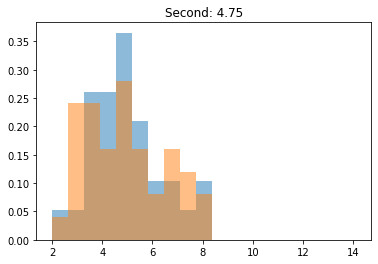

5.1599809347494325 4.975992544478042
Ttest_indResult(statistic=-0.3907075460615227, pvalue=0.6972348132735421)
MannwhitneyuResult(statistic=591.0, pvalue=0.4598242725465756)


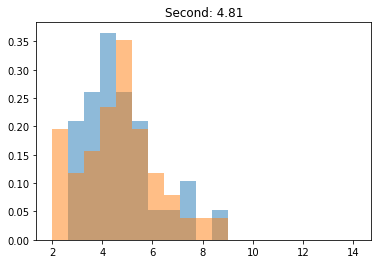

4.67433850899 4.708384654156938
Ttest_indResult(statistic=0.09344760050486059, pvalue=0.9258227660586145)
MannwhitneyuResult(statistic=596.0, pvalue=0.48343375556735046)


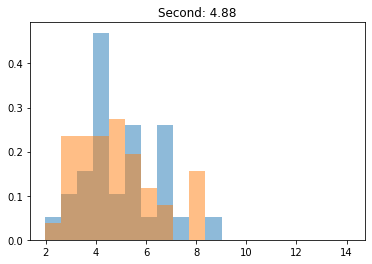

4.854865936594723 5.003669175940289
Ttest_indResult(statistic=0.39803718831145823, pvalue=0.6918496973411951)
MannwhitneyuResult(statistic=536.0, pvalue=0.2255428142330319)


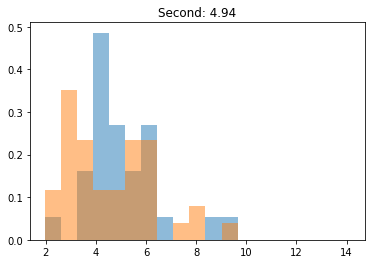

4.6316973221595985 4.91135307785537
Ttest_indResult(statistic=0.6980220953226913, pvalue=0.4875434988860913)
MannwhitneyuResult(statistic=521.0, pvalue=0.17576554070906575)


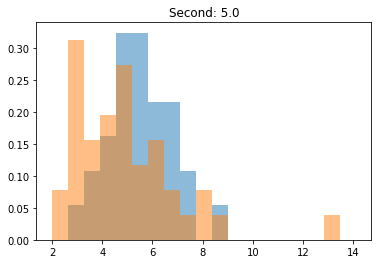

4.910285180374077 5.406851227572684
Ttest_indResult(statistic=1.1116774768337045, pvalue=0.27019187488761653)
MannwhitneyuResult(statistic=446.0, pvalue=0.03424951165380191)


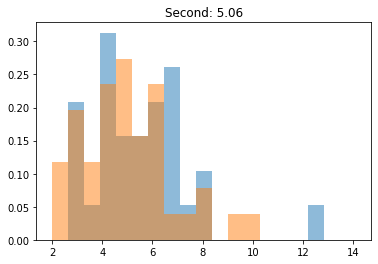

4.951696936799574 5.530123907279243
Ttest_indResult(statistic=1.2424193212262118, pvalue=0.21834946638935646)
MannwhitneyuResult(statistic=482.0, pvalue=0.08158809544473267)


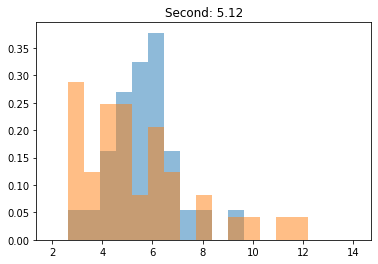

5.251325850764962 5.562341617160005
Ttest_indResult(statistic=0.6264502831331344, pvalue=0.5331170578000017)
MannwhitneyuResult(statistic=470.0, pvalue=0.06216107378445512)


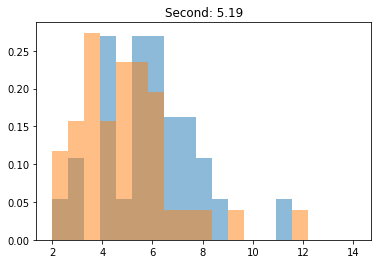

4.966559144046105 5.768874505982784
Ttest_indResult(statistic=1.6774564807804961, pvalue=0.09804445118397495)
MannwhitneyuResult(statistic=424.0, pvalue=0.018634646264467425)


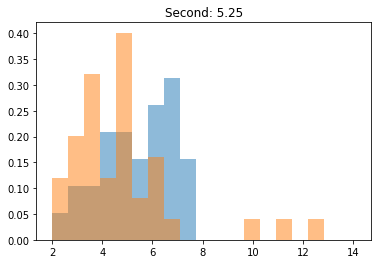

5.115106207994232 5.406341028706575
Ttest_indResult(statistic=0.5020880237969697, pvalue=0.6172275764682223)
MannwhitneyuResult(statistic=424.0, pvalue=0.018634646264467425)


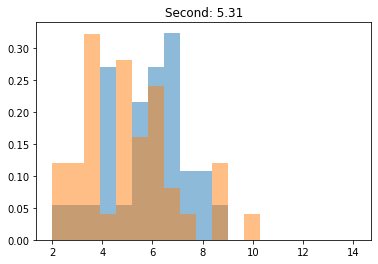

4.971635920329938 5.663838995512909
Ttest_indResult(statistic=1.5365056034679907, pvalue=0.1290547067730975)
MannwhitneyuResult(statistic=443.0, pvalue=0.03163329699397895)


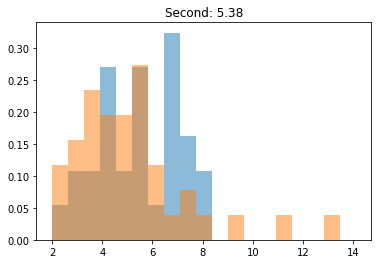

5.1403471987345295 5.365099057160416
Ttest_indResult(statistic=0.45122708232084346, pvalue=0.6532616392050952)
MannwhitneyuResult(statistic=494.0, pvalue=0.10527497560318327)


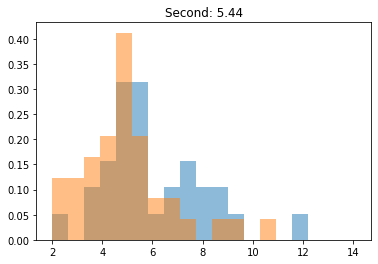

5.132288534368218 6.083160359669889
Ttest_indResult(statistic=1.7286524182614997, pvalue=0.08840958136061373)
MannwhitneyuResult(statistic=399.0, pvalue=0.008668136781915138)


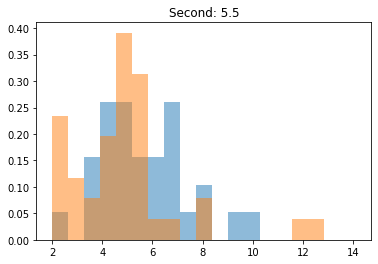

4.934867142093087 5.703557161396631
Ttest_indResult(statistic=1.572578398623943, pvalue=0.1204581524088982)
MannwhitneyuResult(statistic=438.0, pvalue=0.027641054518560016)


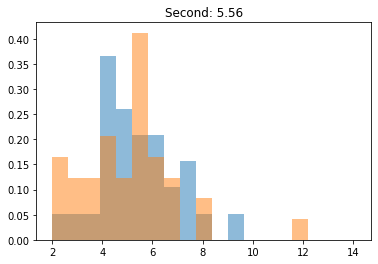

5.229258320996027 5.418121464400454
Ttest_indResult(statistic=0.3597224344222658, pvalue=0.7201694907675019)
MannwhitneyuResult(statistic=528.0, pvalue=0.1980661797309871)


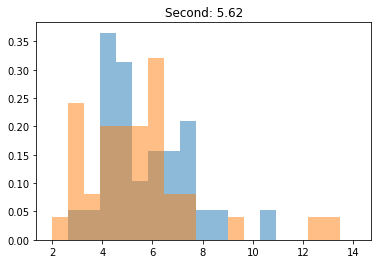

5.361964203079304 5.77730681949489
Ttest_indResult(statistic=0.8151567385674828, pvalue=0.41782854787763835)
MannwhitneyuResult(statistic=496.0, pvalue=0.10966361758007842)


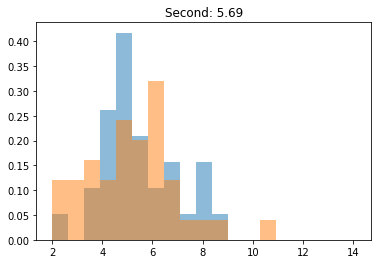

5.458939384392109 5.488535841069437
Ttest_indResult(statistic=0.060907072709253204, pvalue=0.9516118760624421)
MannwhitneyuResult(statistic=577.0, pvalue=0.3947246201466327)


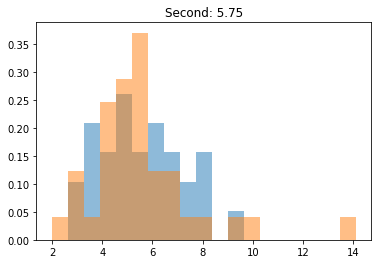

6.036457795161302 5.541770694852995
Ttest_indResult(statistic=-0.811163560216344, pvalue=0.4201019182591602)
MannwhitneyuResult(statistic=593.0, pvalue=0.4692557648922275)


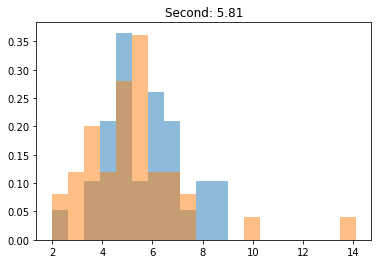

5.48775217491618 5.67242459603379
Ttest_indResult(statistic=0.3358655407058962, pvalue=0.7380063901485449)
MannwhitneyuResult(statistic=493.0, pvalue=0.10312892864173584)


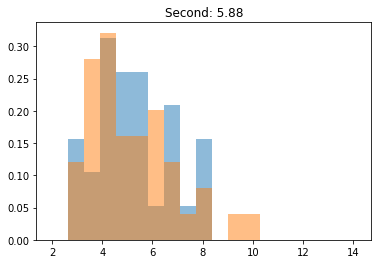

5.497329989566241 5.337414169071747
Ttest_indResult(statistic=-0.2880908157259621, pvalue=0.7741534969755286)
MannwhitneyuResult(statistic=569.0, pvalue=0.35868782018733764)


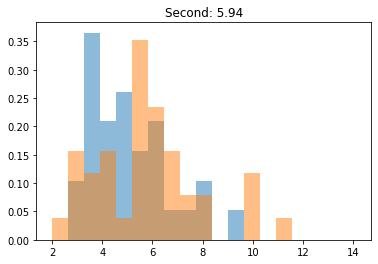

5.819735691668391 5.10894161811191
Ttest_indResult(statistic=-1.5364868938035086, pvalue=0.12905928873002298)
MannwhitneyuResult(statistic=475.0, pvalue=0.06976504833537771)


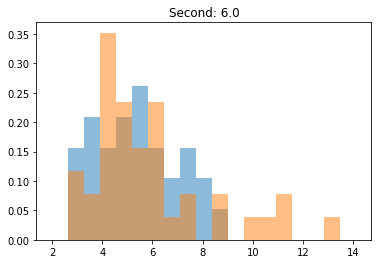

5.933166098741324 5.387391870180162
Ttest_indResult(statistic=-1.0404193203806027, pvalue=0.30183031728222653)
MannwhitneyuResult(statistic=565.0, pvalue=0.3411085153778096)


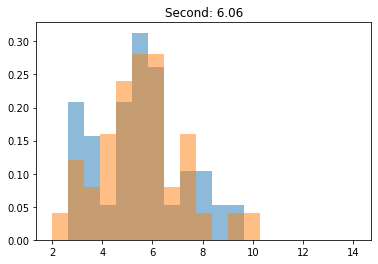

5.761296699348722 5.56006263604704
Ttest_indResult(statistic=-0.3822284596392979, pvalue=0.7034839203215191)
MannwhitneyuResult(statistic=598.0, pvalue=0.49289851436457083)


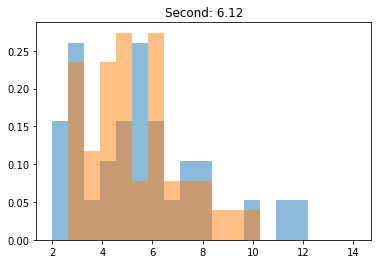

5.318702789597902 5.509492703133416
Ttest_indResult(statistic=0.36455699110062256, pvalue=0.7165733973905576)
MannwhitneyuResult(statistic=595.0, pvalue=0.47870454117454486)


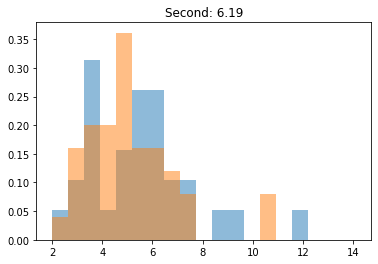

5.423759387130694 5.5464297590104845
Ttest_indResult(statistic=0.22232601276535383, pvalue=0.8247265090482678)
MannwhitneyuResult(statistic=567.0, pvalue=0.34985793562805334)


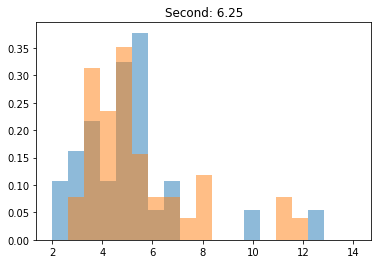

5.388353870342644 5.443497160440139
Ttest_indResult(statistic=0.08924329901784799, pvalue=0.9291508829451929)
MannwhitneyuResult(statistic=593.0, pvalue=0.4692557648922275)


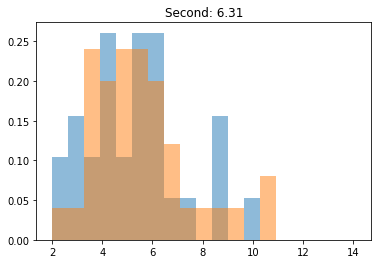

5.716496591292037 5.32817206650842
Ttest_indResult(statistic=-0.7212646350247187, pvalue=0.4732193424413772)
MannwhitneyuResult(statistic=576.0, pvalue=0.39016320569654583)


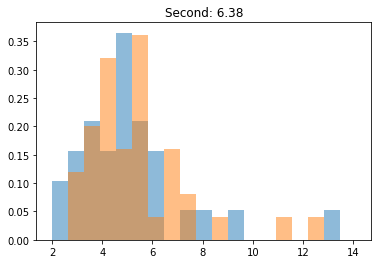

5.323959221066897 5.051962572956053
Ttest_indResult(statistic=-0.528801000108614, pvalue=0.5986653703632252)
MannwhitneyuResult(statistic=527.0, pvalue=0.19477969110450688)


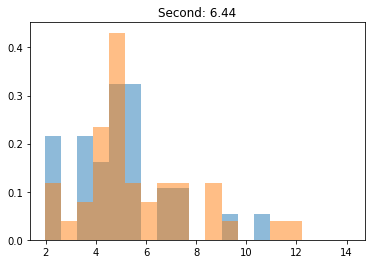

5.658578057355643 5.390747530012297
Ttest_indResult(statistic=-0.4633691250210311, pvalue=0.64457951819865)
MannwhitneyuResult(statistic=543.0, pvalue=0.25125947286121564)


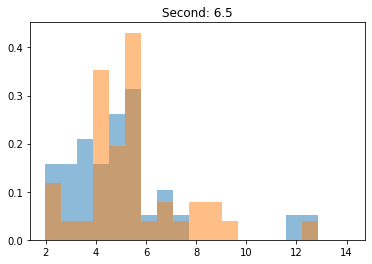

5.476448815225751 5.044311423754929
Ttest_indResult(statistic=-0.8277608456014014, pvalue=0.4107016108534839)
MannwhitneyuResult(statistic=484.0, pvalue=0.08522913065257437)


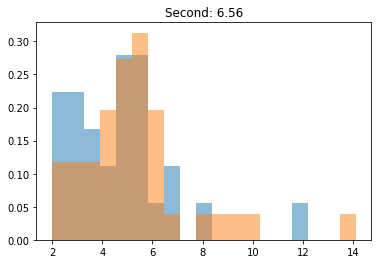

5.289399755925084 4.957920051733452
Ttest_indResult(statistic=-0.5487169556117072, pvalue=0.584996918896814)
MannwhitneyuResult(statistic=502.0, pvalue=0.12361327843741898)


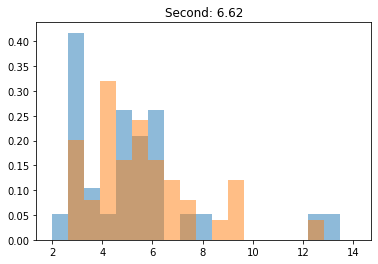

5.473136300576459 5.1764236279276385
Ttest_indResult(statistic=-0.5232644227946514, pvalue=0.6024913054854881)
MannwhitneyuResult(statistic=514.0, pvalue=0.15512482814011969)


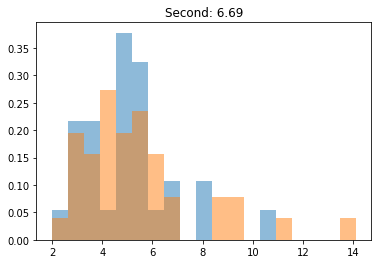

5.463016823949717 5.337238469287646
Ttest_indResult(statistic=-0.215642630252067, pvalue=0.8299118398758686)
MannwhitneyuResult(statistic=581.0, pvalue=0.41310902364314284)


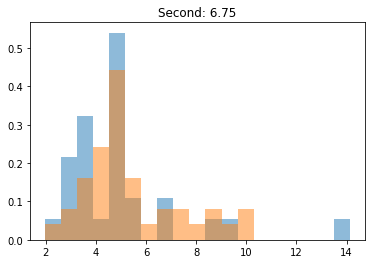

5.8239538932554735 5.3347002083075665
Ttest_indResult(statistic=-0.6515974278530003, pvalue=0.5168571469878761)
MannwhitneyuResult(statistic=491.0, pvalue=0.09893250266603837)


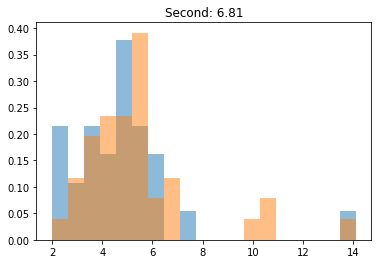

5.394868076060665 5.128605497850572
Ttest_indResult(statistic=-0.42332162252584055, pvalue=0.673396529280464)
MannwhitneyuResult(statistic=511.0, pvalue=0.14678969640683837)


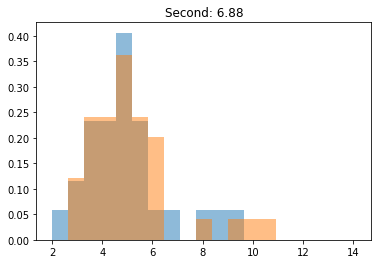

5.557166640514135 5.1636515908150376
Ttest_indResult(statistic=-0.524054780521027, pvalue=0.601944457031877)
MannwhitneyuResult(statistic=519.0, pvalue=0.16969803082055623)


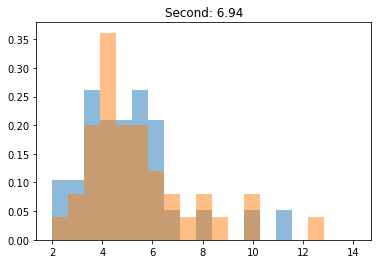

5.8998791667390424 5.056369538802883
Ttest_indResult(statistic=-1.2323992658218972, pvalue=0.2220441351112958)
MannwhitneyuResult(statistic=534.0, pvalue=0.21847851499660348)


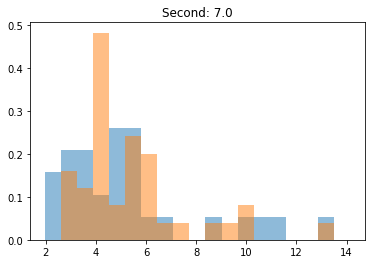

6.0189249012864625 5.320234056204886
Ttest_indResult(statistic=-0.7993054593405944, pvalue=0.42689653852971265)
MannwhitneyuResult(statistic=516.0, pvalue=0.16085190079965855)


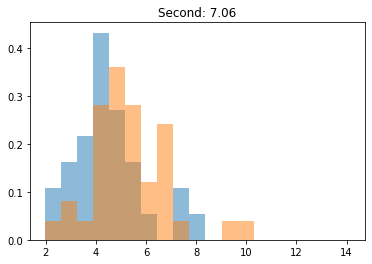

5.9007243713207 4.907632294034172
Ttest_indResult(statistic=-1.2453596237084357, pvalue=0.21727391300058685)
MannwhitneyuResult(statistic=404.0, pvalue=0.01016616201900315)


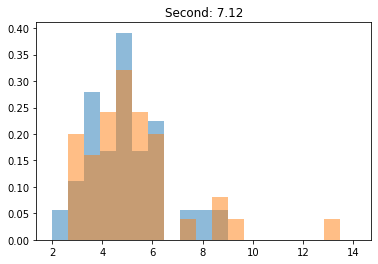

5.715188751265089 4.724745332076031
Ttest_indResult(statistic=-1.369284838187393, pvalue=0.17541586007268292)
MannwhitneyuResult(statistic=527.0, pvalue=0.19477969110450688)


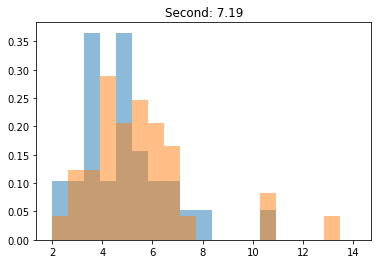

5.997014188686917 4.907784266488552
Ttest_indResult(statistic=-1.7176771461036842, pvalue=0.09040662739781961)
MannwhitneyuResult(statistic=476.0, pvalue=0.07136837663088619)


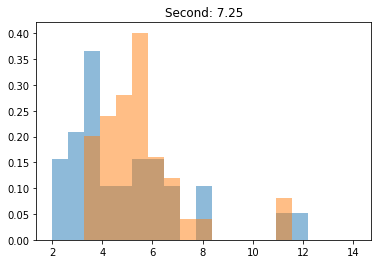

5.787642100647217 4.98626560007936
Ttest_indResult(statistic=-1.3808994611694994, pvalue=0.17183158724373093)
MannwhitneyuResult(statistic=432.0, pvalue=0.023413627811504696)


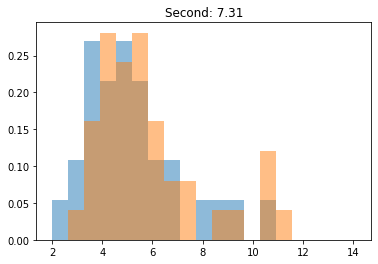

6.384470993196662 5.562307159961415
Ttest_indResult(statistic=-0.9512991054177152, pvalue=0.3448216755546235)
MannwhitneyuResult(statistic=511.0, pvalue=0.14678969640683837)


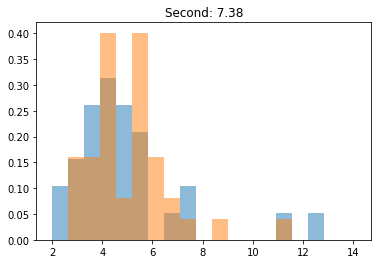

5.3763602385048594 4.967521103328134
Ttest_indResult(statistic=-0.7114720453811089, pvalue=0.4792254009249246)
MannwhitneyuResult(statistic=503.0, pvalue=0.12605398601710915)


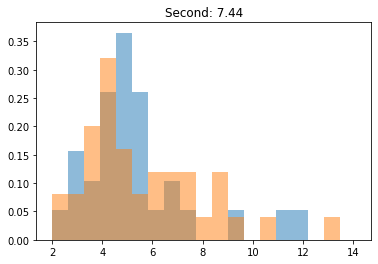

5.574731303150131 5.421083416746058
Ttest_indResult(statistic=-0.2718727744546342, pvalue=0.7865435998538726)
MannwhitneyuResult(statistic=596.0, pvalue=0.48343375556735046)


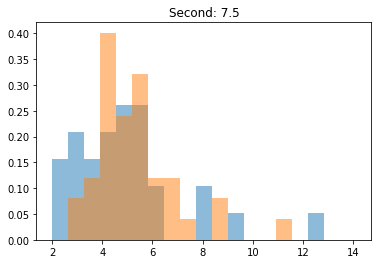

6.259769850545515 4.887935146776999
Ttest_indResult(statistic=-1.1740080439786986, pvalue=0.24448717634473188)
MannwhitneyuResult(statistic=455.0, pvalue=0.04318182753553202)


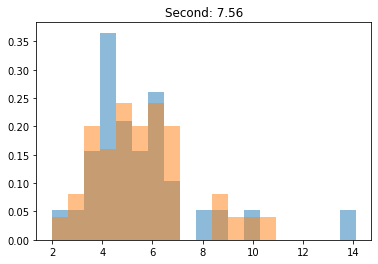

5.862042434137585 5.469755298480853
Ttest_indResult(statistic=-0.6501091962810269, pvalue=0.5178120625793687)
MannwhitneyuResult(statistic=531.0, pvalue=0.2081246713393723)


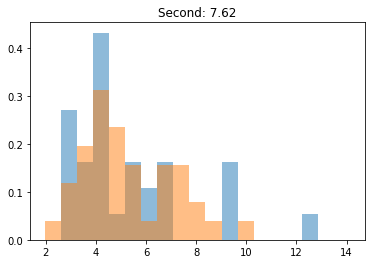

5.32667570625185 5.155504746429548
Ttest_indResult(statistic=-0.3409932576502162, pvalue=0.734160014401462)
MannwhitneyuResult(statistic=519.0, pvalue=0.16969803082055623)


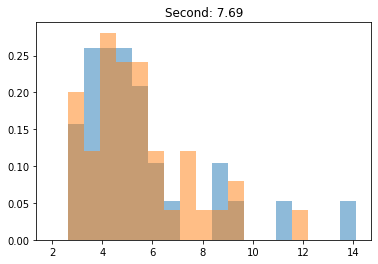

5.901346097006157 5.5354853879426384
Ttest_indResult(statistic=-0.4754818554149221, pvalue=0.6359674468857927)
MannwhitneyuResult(statistic=560.0, pvalue=0.3196138935484081)


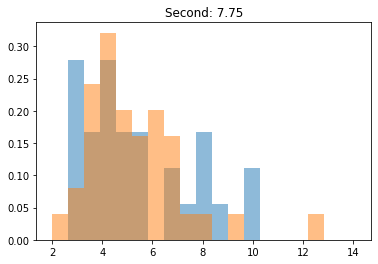

5.763336407079576 6.258700594593088
Ttest_indResult(statistic=0.54035443411079, pvalue=0.590718112594405)
MannwhitneyuResult(statistic=571.0, pvalue=0.3675938903658421)


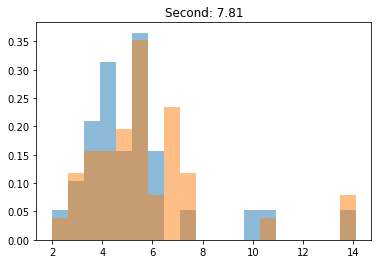

5.695362419570768 5.3269960668584
Ttest_indResult(statistic=-0.6267327053754074, pvalue=0.5329329883590421)
MannwhitneyuResult(statistic=501.0, pvalue=0.12120585814586599)


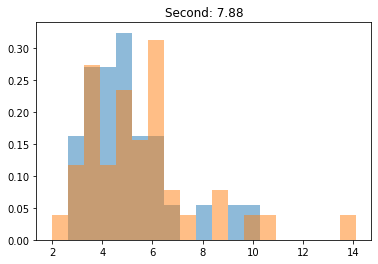

5.509166854999337 5.598828673445303
Ttest_indResult(statistic=0.12892317849339419, pvalue=0.8977990013660189)
MannwhitneyuResult(statistic=539.0, pvalue=0.23637774836672393)


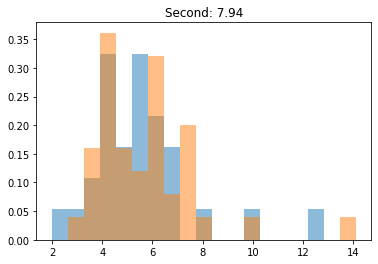

5.900036600997914 6.121012802627968
Ttest_indResult(statistic=0.3076090748594152, pvalue=0.7593200014978291)
MannwhitneyuResult(statistic=586.0, pvalue=0.4363556505447304)


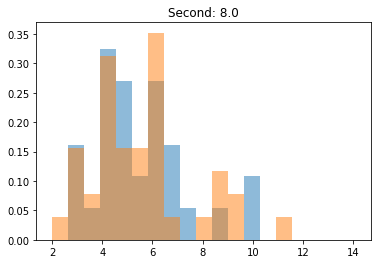

5.562761203850842 6.260254706241559
Ttest_indResult(statistic=0.8801579102589426, pvalue=0.3818738465038689)
MannwhitneyuResult(statistic=568.0, pvalue=0.354263084328722)


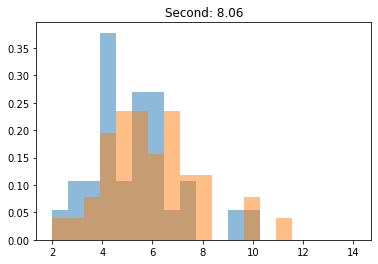

5.9118544331686795 6.018515541162535
Ttest_indResult(statistic=0.1400234246774172, pvalue=0.8890554083293298)
MannwhitneyuResult(statistic=495.0, pvalue=0.10745314872454437)


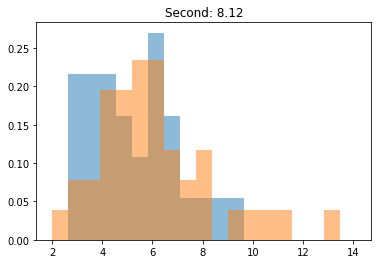

6.046821049307136 5.911929445433791
Ttest_indResult(statistic=-0.17760662814365447, pvalue=0.8595599225277248)
MannwhitneyuResult(statistic=511.0, pvalue=0.14678969640683837)


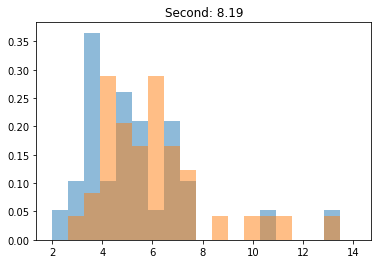

6.583119334896688 5.355267840356663
Ttest_indResult(statistic=-1.8474547061985367, pvalue=0.06903154248540458)
MannwhitneyuResult(statistic=425.0, pvalue=0.019182482442405557)


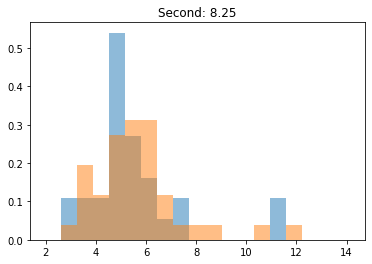

5.692882231095847 5.829774951910594
Ttest_indResult(statistic=0.25327752804884923, pvalue=0.8008179273778008)
MannwhitneyuResult(statistic=532.0, pvalue=0.21154335596563079)


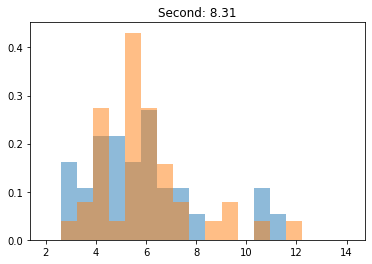

5.991950961876007 6.542113777803984
Ttest_indResult(statistic=0.6782748844531389, pvalue=0.4998991407752511)
MannwhitneyuResult(statistic=565.0, pvalue=0.3411085153778096)


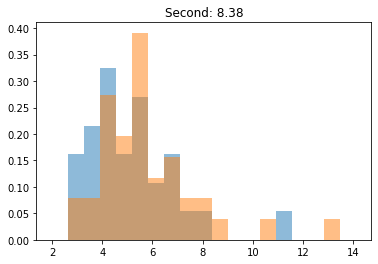

5.722422766738421 5.550041298082179
Ttest_indResult(statistic=-0.3053138505070565, pvalue=0.7610597589146073)
MannwhitneyuResult(statistic=508.0, pvalue=0.13876046422598942)


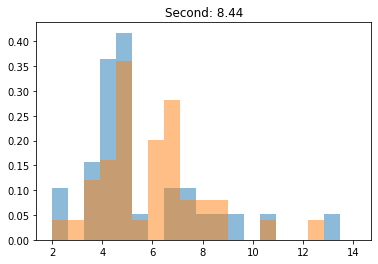

5.865673224755874 5.579133435121124
Ttest_indResult(statistic=-0.5238116790779848, pvalue=0.6021126345435022)
MannwhitneyuResult(statistic=519.0, pvalue=0.16969803082055623)


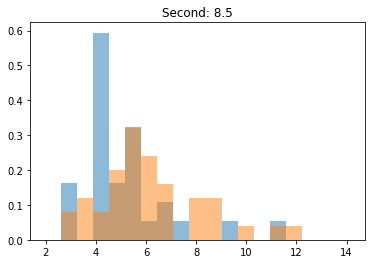

6.455793495323675 6.4353977609459845
Ttest_indResult(statistic=-0.016912186323565916, pvalue=0.9865561952684775)
MannwhitneyuResult(statistic=413.0, pvalue=0.013436838514690469)


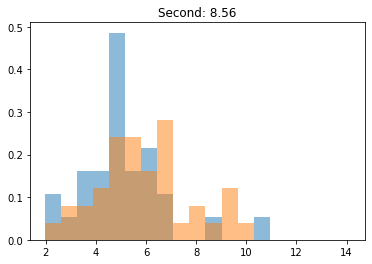

6.195367546317959 5.57232344947559
Ttest_indResult(statistic=-1.0373286241349724, pvalue=0.3032574442912692)
MannwhitneyuResult(statistic=435.0, pvalue=0.02545391949326283)


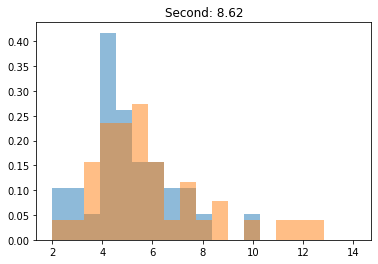

5.888469789110141 5.110792582325936
Ttest_indResult(statistic=-1.5395924771787546, pvalue=0.12830050509360194)
MannwhitneyuResult(statistic=491.0, pvalue=0.09893250266603837)


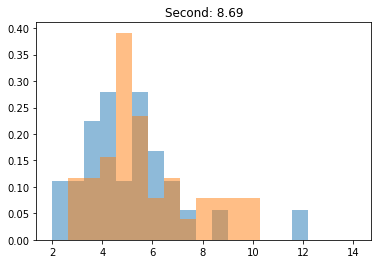

5.7729678794089905 5.652496659634673
Ttest_indResult(statistic=-0.16424422537295394, pvalue=0.8700261182248195)
MannwhitneyuResult(statistic=495.0, pvalue=0.10745314872454437)


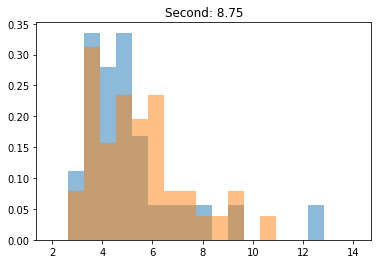

5.53649706603634 5.73309697553245
Ttest_indResult(statistic=0.258914629623142, pvalue=0.7964832712677983)
MannwhitneyuResult(statistic=512.0, pvalue=0.14953403510319657)


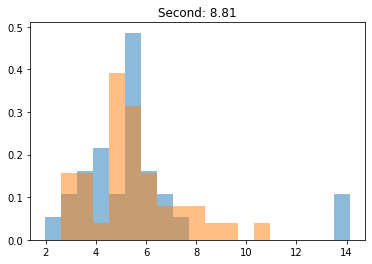

5.454217887360061 5.494699212243388
Ttest_indResult(statistic=0.07825044312571888, pvalue=0.9378586437941845)
MannwhitneyuResult(statistic=571.0, pvalue=0.3675938903658421)


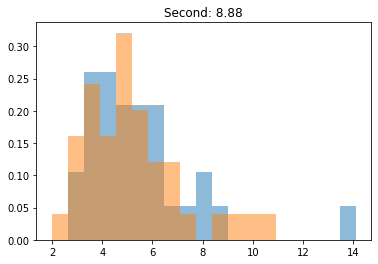

5.527892707627368 5.399378920374717
Ttest_indResult(statistic=-0.20909369551729903, pvalue=0.8350002164215222)
MannwhitneyuResult(statistic=590.0, pvalue=0.4551166562426733)


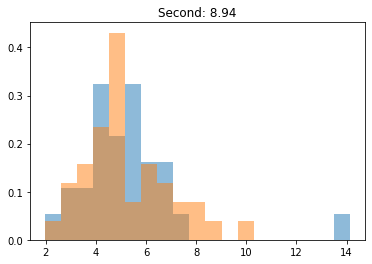

5.256791266021816 5.567549636019639
Ttest_indResult(statistic=0.5989348066354286, pvalue=0.5512065092628045)
MannwhitneyuResult(statistic=588.0, pvalue=0.4457209603480758)


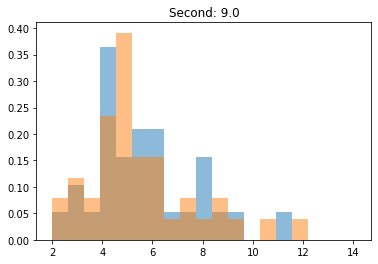

5.524557264970802 5.69622285101602
Ttest_indResult(statistic=0.3331931924297099, pvalue=0.7400136258186426)
MannwhitneyuResult(statistic=564.0, pvalue=0.33676528128783534)


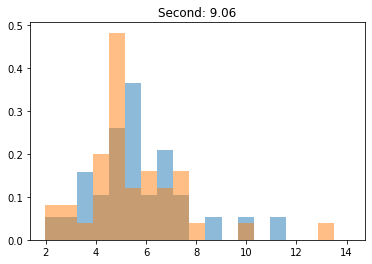

5.490845763559411 5.663846274098832
Ttest_indResult(statistic=0.3538216728971625, pvalue=0.7245672438073034)
MannwhitneyuResult(statistic=548.0, pvalue=0.2705360561298235)


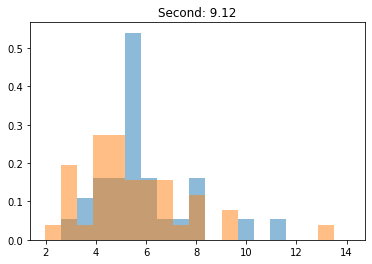

5.474023327864782 5.734956616876485
Ttest_indResult(statistic=0.5229038692247726, pvalue=0.6027408484224641)
MannwhitneyuResult(statistic=535.0, pvalue=0.2219946209944199)


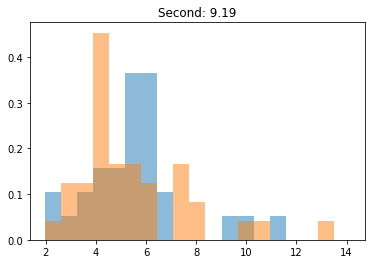

6.166125195354081 5.523802214083899
Ttest_indResult(statistic=-0.8434686619558761, pvalue=0.4019237375741854)
MannwhitneyuResult(statistic=570.0, pvalue=0.3631316043748767)


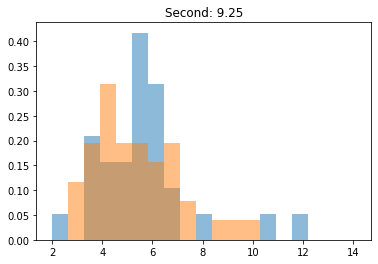

5.32931842132327 5.658290351700028
Ttest_indResult(statistic=0.7624821513163397, pvalue=0.4484091634079366)
MannwhitneyuResult(statistic=542.0, pvalue=0.24749320062960456)


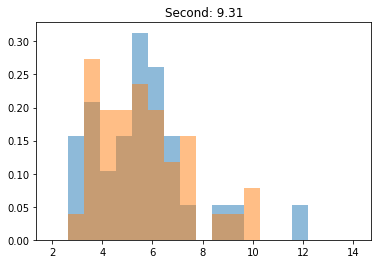

5.5741077168686575 5.593120831225849
Ttest_indResult(statistic=0.04176270234439132, pvalue=0.9668102518664818)
MannwhitneyuResult(statistic=597.0, pvalue=0.48816530181036105)


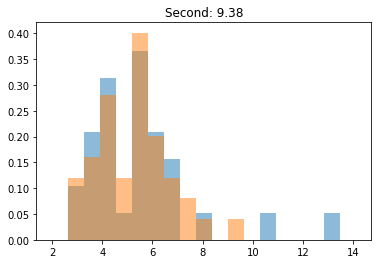

5.642085206809372 5.449045975586683
Ttest_indResult(statistic=-0.30678832388942656, pvalue=0.7599419801617094)
MannwhitneyuResult(statistic=579.0, pvalue=0.40389028235045416)


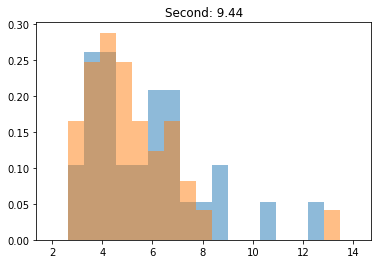

5.414363751290688 5.787374012259829
Ttest_indResult(statistic=0.5969954136274659, pvalue=0.5524930696196519)
MannwhitneyuResult(statistic=525.0, pvalue=0.18830699234381937)


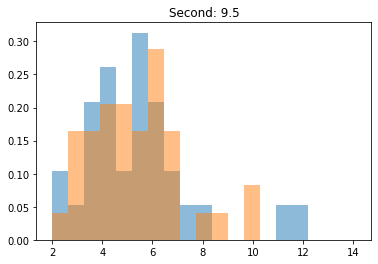

5.790289651988528 5.4585143869059225
Ttest_indResult(statistic=-0.53985794883501, pvalue=0.5910586075712401)
MannwhitneyuResult(statistic=571.0, pvalue=0.3675938903658421)


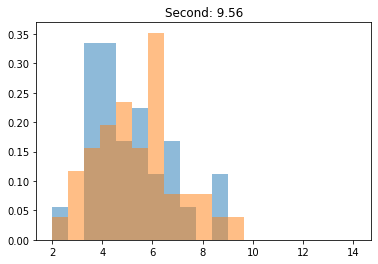

5.3777329450473195 5.940078665647972
Ttest_indResult(statistic=0.8606336581580111, pvalue=0.39246423293217336)
MannwhitneyuResult(statistic=576.0, pvalue=0.39016320569654583)


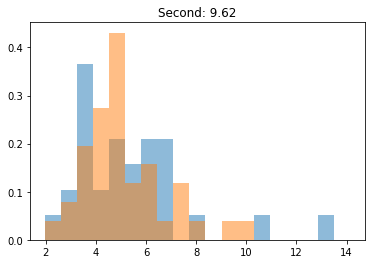

5.149202355698206 5.3610158048967484
Ttest_indResult(statistic=0.44681823450869773, pvalue=0.6564261650041159)
MannwhitneyuResult(statistic=594.0, pvalue=0.47397832318630867)


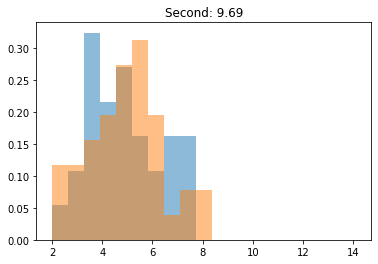

4.8923373944564155 5.21990342334185
Ttest_indResult(statistic=0.7080734889649797, pvalue=0.481319727438127)
MannwhitneyuResult(statistic=593.0, pvalue=0.4692557648922275)


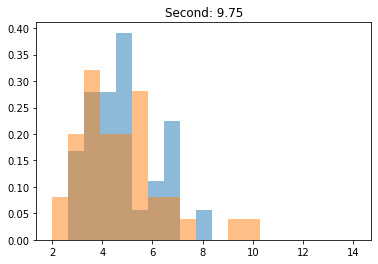

4.628758729099054 5.005543392479342
Ttest_indResult(statistic=0.7805247885231547, pvalue=0.4377907100901214)
MannwhitneyuResult(statistic=561.0, pvalue=0.3238675307405706)


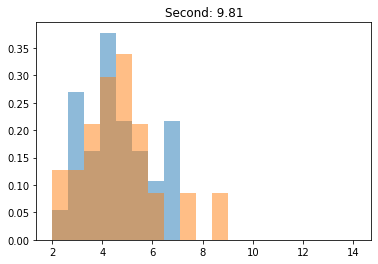

4.932192885140014 4.871502758785332
Ttest_indResult(statistic=-0.09127460437717895, pvalue=0.9275427436985328)
MannwhitneyuResult(statistic=596.0, pvalue=0.48343375556735046)


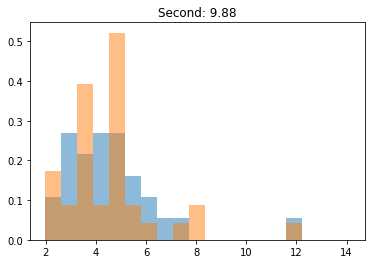

4.335583113567713 4.5445940264777835
Ttest_indResult(statistic=0.43112467387619885, pvalue=0.6677413756548536)
MannwhitneyuResult(statistic=551.0, pvalue=0.2824464737302744)


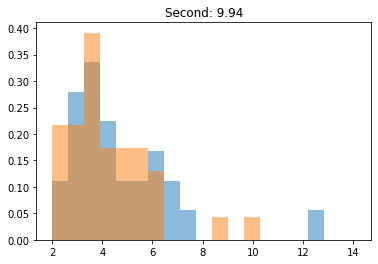

3.981361093169992 4.443116873395342
Ttest_indResult(statistic=0.9667147617627939, pvalue=0.33711233169219923)
MannwhitneyuResult(statistic=526.0, pvalue=0.19152659054364674)


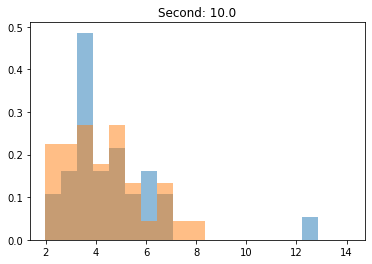

4.040933383629773 4.494442612596417
Ttest_indResult(statistic=1.0297227035697654, pvalue=0.30678897042911635)
MannwhitneyuResult(statistic=534.0, pvalue=0.21847851499660348)


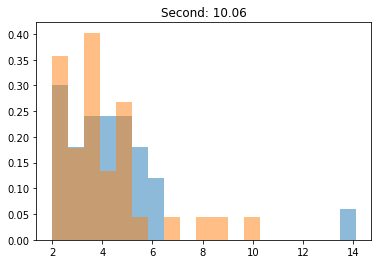

3.788804081299965 4.009050900348573
Ttest_indResult(statistic=0.4276160461195875, pvalue=0.6702818439460301)
MannwhitneyuResult(statistic=542.0, pvalue=0.24749320062960456)


In [1969]:
for index, (sample_empty_window, sample_other_window) in enumerate(zip(sample_empty.T, sample_other.T)):
    test_results = mannwhitneyu(sample_other_window, sample_empty_window)
#     if test_results.pvalue < 0.05:
    plt.title("Second: " + str(round(index / 16, 2)))
    plt.hist(sample_other_window, bins=bins, alpha=0.5, density=True)
    plt.hist(sample_empty_window, bins=bins, alpha=0.5, density=True)
    plt.show()
    print(sample_empty_window.mean(), sample_other_window.mean())
    print(ttest_ind(sample_other_window, sample_empty_window))
    print(test_results)

В течение какого времени падает вознаграждение

In [1874]:
0.95 ** 10

0.5987369392383787

In [1875]:
0.85 ** 10

0.1968744043407226

In [1878]:
0.7 ** 10

0.028247524899999984

In [1873]:
from scipy.stats import mannwhitneyu

In [1760]:
from scipy.stats import ttest_ind

5.915029118704833

5.892106627258252

Ttest_indResult(statistic=0.07193255925526007, pvalue=0.9427048225948553)

In [1764]:
mannwhitneyu(sample_other, sample_empty)

MannwhitneyuResult(statistic=3602.0, pvalue=0.1448535977192527)